In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ga
import importlib

from ga import *
from tradingrule_changelogr import *

### Data preprocessing

In [2]:
data = pd.read_csv("data/AUDUSD_M5.csv")
data = data[['Open', 'High', 'Low', 'Close']]
data.head()

,Open,High,Low,Close
0,0.70613,0.70613,0.70575,0.70575
1,0.70575,0.70579,0.70568,0.70579
2,0.70579,0.70598,0.70578,0.70595
3,0.70596,0.70618,0.70594,0.70618
4,0.70618,0.70628,0.70593,0.70595


In [3]:
X_train = data.loc[:len(data)//2]
X_test = data.loc[len(data)//2:]

In [4]:
%%time
trading_rule_params = trainTradingRuleFeatures(X_train)

Training Rule1 score is: 0.298
Training Rule2 score is: 0.298
Training Rule3 score is: 0.320
Training Rule4 score is: 0.299
Training Rule5 score is: 0.278
Training Rule6 score is: 0.316
Training Rule7 score is: 0.325
Training Rule8 score is: 0.262
Training Rule9 score is: 0.320
Training Rule10 score is: 0.326
Training Rule11 score is: 0.257
Training Rule12 score is: 0.324
Training Rule13 score is: 0.257
Training Rule14 score is: 0.170
Training Rule15 score is: 0.123
Training Rule16 score is: 0.084
CPU times: user 3min 6s, sys: 4.01 s, total: 3min 10s
Wall time: 2min 59s


In [5]:
%%time
X_trading_rule_train = getTradingRuleFeatures(X_train, trading_rule_params)
X_trading_rule_test = getTradingRuleFeatures(X_test, trading_rule_params)

CPU times: user 3.69 s, sys: 19.7 ms, total: 3.71 s
Wall time: 3.65 s


### Genetic Algorithm to Find the Optimal Combination of Rules

In [6]:
def evaluate(position, logr):
    port_r = logr*position
    score = port_r.sum()
    print("The maximum position is {:.3f}, the mean postiion is {:3f}.".format(position.max(), abs(position).mean()))
    print("The return over the period is: {:.2f}%".format(score*100))
    print("Maximum drawdown is: {:.3f}%".format(min(port_r.cumsum())*100))
    sr_train = port_r.mean()/port_r.std()
    print("SR ratio is: {:.3f}".format(sr_train*(252*24*12)**0.5))

### 思考下为什么曲线会突然就往下打下去，SSR应该是maximize优化

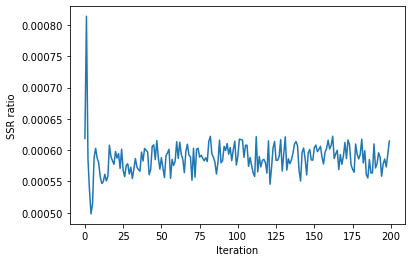

CPU times: user 34.2 s, sys: 2.02 s, total: 36.2 s
Wall time: 36.2 s


In [7]:
%%time
max_SSR_weights = GA_train(X_trading_rule_train, optimizing_selection=2, sol_per_pop=10, num_parents_mating=6, num_generations = 200)

In [8]:
position = (X_trading_rule_train.values[:, 1:]@max_SSR_weights.T).reshape(X_trading_rule_train.shape[0],)
position /= np.max(abs(position))
print('Training data evaluation:')
evaluate(position, X_trading_rule_train.logr)
port_r_train = X_trading_rule_train.logr*position

Training data evaluation:
The maximum position is 1.000, the mean postiion is 0.423946.
The return over the period is: 15.68%
Maximum drawdown is: -0.593%
SR ratio is: 9.120


In [9]:
position = (X_trading_rule_test.values[:, 1:]@max_SSR_weights.T).reshape(X_trading_rule_test.shape[0],)
position /= np.max(abs(position))
print('Testing data evaluation:')
evaluate(position, X_trading_rule_test.logr)
port_r_test = X_trading_rule_test.logr*position

Testing data evaluation:
The maximum position is 0.964, the mean postiion is 0.453195.
The return over the period is: 8.27%
Maximum drawdown is: -0.082%
SR ratio is: 5.924


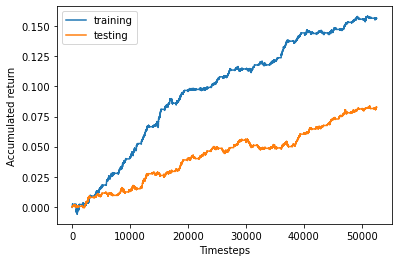

In [10]:
plt.plot(range(len(port_r_train)), port_r_train.cumsum(), label='training')
plt.plot(range(len(port_r_test)), port_r_test.cumsum(), label='testing')
plt.xlabel('Timesteps')
plt.ylabel('Accumulated return')
plt.legend()
plt.show()